#  Q-learning

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Саттон Р.	С.,	Барто Э. Дж. Обучение с подкреплением: Введение. 2-е изд.
* https://gymnasium.farama.org/tutorials/training_agents/blackjack_tutorial/
* https://en.wikipedia.org/wiki/Q-learning
* https://www.baeldung.com/cs/epsilon-greedy-q-learning
* https://pythonprogramming.net/q-learning-reinforcement-learning-python-tutorial/
* https://www.datacamp.com/tutorial/introduction-q-learning-beginner-tutorial
* https://rubikscode.net/2021/07/20/introduction-to-double-q-learning/
* https://gymnasium.farama.org/api/wrappers/misc_wrappers/#gymnasium.wrappers.RecordVideo

## Задачи для совместного разбора

1\. Рассмотрите понятие Q-функции, ее применение для формирования политики агента и способов ее создания.

## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Обучите агента для игры в блэкджек (окружение `Blackjack-v1`), используя алгоритм Q-learning. Для создания таблицы Q-функции выясните размеры пространства состояния игры и количество возможных действий игрока и выведите эти значения на экран. Во время обучения несколько раз вычислите статистику за `print_every` последних эпизодов: количество выигранных и проигранных сессий. После завершения обучения визуализируйте полученные данные. Изучите, как выглядит Q-функция (в каких состояниях игрок будет брать карту, в каких - нет). Cыграйте `N=10000` игр, применяя стратегию, выведенную из обученной Q-функции, посчитайте и выведите на экран долю выигранных игр.

Cтратегия для выбора действия:
$$a_{t+1}(s_t) = argmax_aQ(s_t, a)$$

Правило обновления Q-функции:

![q-learning](https://wikimedia.org/api/rest_v1/media/math/render/svg/d247db9eaad4bd343e7882ec546bf3847ebd36d8)

- [ ] Проверено на семинаре

In [ ]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm
from dataclasses import dataclass
import matplotlib.pyplot as plt
import seaborn as sns
@dataclass
class Config:
    discount: float = 0.95
    lr: float = 0.005
    n_episodes: float = 500_000
    print_every: int = 5000

Начинаем обучение Q-learning...


Ep: 500000 | WinRate: 43.72%: 100%|██████████████████████████████████████████| 500000/500000 [03:05<00:00, 2696.68it/s]



Визуализация полученной стратегии:


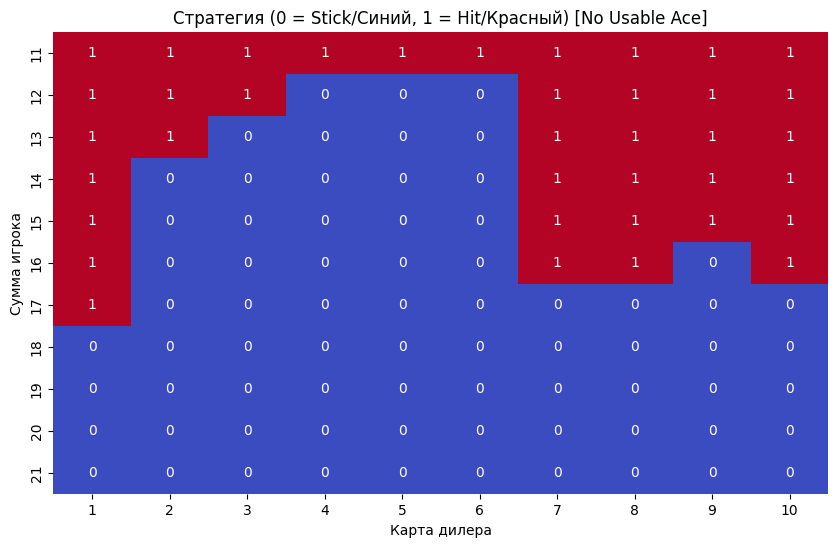

Доля выигрышей обученного агента: 0.4186


In [ ]:
class QAgent:
    def __init__(self, env: gym.Env, config: Config):
        self.env = env
        self.cfg = config
        self._create_q_table()

    def _create_q_table(self):
        self.q_table = np.zeros((32, 11, 2, 2))

    def get_action(self, state: tuple) -> int:

        player_sum, dealer_card, usable_ace = state
        usable_ace = int(usable_ace)

        q_values = self.q_table[player_sum, dealer_card, usable_ace, :]
        return int(np.argmax(q_values))

    def update_q_table(self, state, action, reward, next_state, done):
        p_sum, d_card, u_ace = state
        u_ace = int(u_ace)
        next_p_sum, next_d_card, next_u_ace = next_state
        next_u_ace = int(next_u_ace)
        current_q = self.q_table[p_sum, d_card, u_ace, action]
        if done:
            max_future_q = 0.0
        else:
            max_future_q = np.max(self.q_table[next_p_sum, next_d_card, next_u_ace, :])

        # Q_new = Q_old + lr * (Reward + gamma * max_future_Q - Q_old)
        target = reward + self.cfg.discount * max_future_q
        new_q = current_q + self.cfg.lr * (target - current_q)

        self.q_table[p_sum, d_card, u_ace, action] = new_q

    def run_episode(self):
        state, info = self.env.reset()
        done = False
        total_reward = 0

        while not done:

            p_sum, d_card, u_ace = state
            if np.all(self.q_table[p_sum, d_card, int(u_ace)] == 0):
                action = self.env.action_space.sample()
            else:
                action = self.get_action(state)
            next_state, reward, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated

            self.update_q_table(state, action, reward, next_state, done)

            state = next_state
            total_reward += reward

        return total_reward

    def train(self):
        rewards = []
        wins = 0
        losses = 0
        draws = 0

        pbar = tqdm(range(self.cfg.n_episodes))

        for ep in pbar:
            reward = self.run_episode()
            rewards.append(reward)

            if reward == 1.0: wins += 1
            elif reward == -1.0: losses += 1
            else: draws += 1

            if (ep + 1) % self.cfg.print_every == 0:
                win_rate = wins / self.cfg.print_every
                pbar.set_description(f"Ep: {ep+1} | WinRate: {win_rate:.2%}")
                wins = 0
                losses = 0
                draws = 0

        return rewards

env = gym.make('Blackjack-v1', render_mode=None)
config = Config()
agent = QAgent(env, config)

print("Начинаем обучение Q-learning...")
training_rewards = agent.train()

def plot_policy(q_table):

    policy_grid = np.zeros((11, 10))

    usable_ace = 0

    for i, player_sum in enumerate(range(11, 22)):
        for j, dealer_card in enumerate(range(1, 11)):
            best_action = np.argmax(q_table[player_sum, dealer_card, usable_ace, :])
            policy_grid[i, j] = best_action

    plt.figure(figsize=(10, 6))
    sns.heatmap(policy_grid, annot=True, cbar=False, cmap="coolwarm",
                xticklabels=range(1, 11), yticklabels=range(11, 22))
    plt.title("Стратегия (0 = Stick/Синий, 1 = Hit/Красный) [No Usable Ace]")
    plt.xlabel("Карта дилера")
    plt.ylabel("Сумма игрока")
    plt.show()

print("\nВизуализация полученной стратегии:")
plot_policy(agent.q_table)
test_wins = 0
N_TEST = 10_000

for _ in range(N_TEST):
    state, _ = env.reset()
    done = False
    while not done:
        action = agent.get_action(state)
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        if done and reward == 1.0:
            test_wins += 1

print(f"Доля выигрышей обученного агента: {test_wins/N_TEST:.4f}")
env.close()

<p class="task" id="2"></p>

2\. Повторите решение предыдущей задачи, используя алгоритм $\epsilon$-greedy Q-learning. Исследуйте, как гиперпараметры и способ инициализации значений Q-функции влияют на результат.

Cтратегия для выбора действия:
1. Сгенерировать число $p$ из $U(0, 1)$;
2. Если $p < \epsilon$, то выбрать действие случайным образом;
3. В противном случае $a_{t+1}(s_t) = argmax_aQ(s_t, a)$.

Правило обновления Q-функции:
![q-learning](https://wikimedia.org/api/rest_v1/media/math/render/svg/d247db9eaad4bd343e7882ec546bf3847ebd36d8)

- [ ] Проверено на семинаре

In [ ]:
from dataclasses import dataclass

@dataclass
class Config:
    discount: float = 0.95
    lr: float = 0.01
    n_episodes: int = 500_000

    epsilon_start: float = 1.0
    epsilon_final: float = 0.03
    decay_steps: int = 100_000

    print_every: int = 20000

Старт обучения с Epsilon-Greedy...


Ep: 500000 | WR: 42.84% | Eps: 0.030: 100%|██████████████████████████████████| 500000/500000 [02:54<00:00, 2869.82it/s]


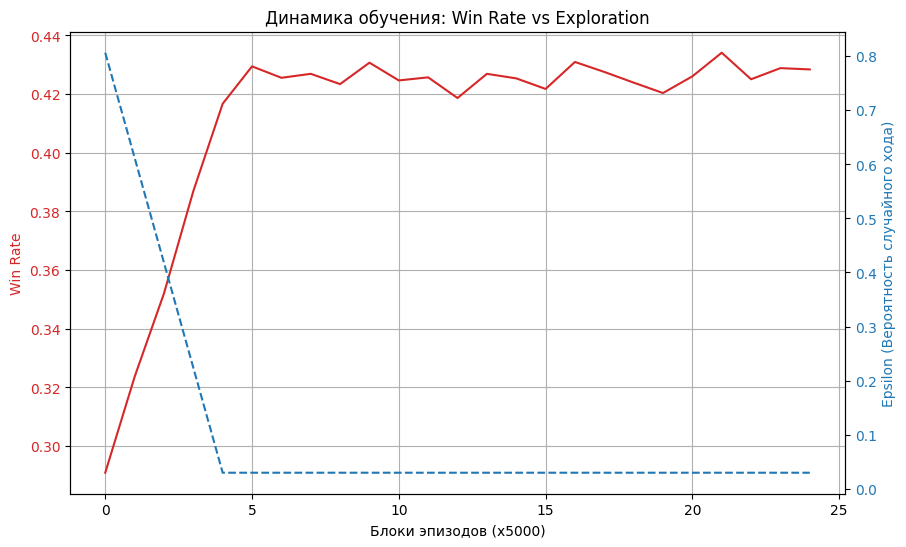


Финальный тест (Greedy, epsilon=0)...
Итоговая точность: 0.4273 (42.73%)


In [ ]:
class EpsilonGreedyAgent:
    def __init__(self, env: gym.Env, config: Config):
        self.env = env
        self.cfg = config

        self.epsilon = self.cfg.epsilon_start
        self.epsilon_decay = (self.cfg.epsilon_start - self.cfg.epsilon_final) / self.cfg.decay_steps

        self._create_q_table()

    def _create_q_table(self):
        self.q_table = np.zeros((32, 11, 2, 2))

    def get_action(self, state: tuple) -> int:
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
            return self._get_best_action(state)

    def _get_best_action(self, state):
        p_sum, d_card, u_ace = state
        return int(np.argmax(self.q_table[p_sum, d_card, int(u_ace), :]))

    def update_q_table(self, state, action, reward, next_state, done):
        p_sum, d_card, u_ace = state
        u_ace = int(u_ace)

        next_p, next_d, next_u = next_state
        next_u = int(next_u)

        current_q = self.q_table[p_sum, d_card, u_ace, action]
        if done:
            max_future_q = 0.0
        else:
            max_future_q = np.max(self.q_table[next_p, next_d, next_u, :])
        target = reward + self.cfg.discount * max_future_q
        new_q = current_q + self.cfg.lr * (target - current_q)

        self.q_table[p_sum, d_card, u_ace, action] = new_q

    def decay_epsilon(self):
        self.epsilon = max(self.cfg.epsilon_final, self.epsilon - self.epsilon_decay)

    def train(self):
        rewards = []
        history_win_rate = []
        history_epsilon = []

        wins = 0

        pbar = tqdm(range(self.cfg.n_episodes))

        for ep in pbar:
            state, _ = self.env.reset()
            done = False

            while not done:
                action = self.get_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated

                self.update_q_table(state, action, reward, next_state, done)
                state = next_state

                if done and reward == 1.0:
                    wins += 1
            self.decay_epsilon()
            if (ep + 1) % self.cfg.print_every == 0:
                current_win_rate = wins / self.cfg.print_every
                history_win_rate.append(current_win_rate)
                history_epsilon.append(self.epsilon)

                pbar.set_description(f"Ep: {ep+1} | WR: {current_win_rate:.2%} | Eps: {self.epsilon:.3f}")
                wins = 0

        return history_win_rate, history_epsilon

env = gym.make('Blackjack-v1', render_mode=None)
config = Config()
agent = EpsilonGreedyAgent(env, config)

print("Старт обучения с Epsilon-Greedy...")
win_rates, epsilons = agent.train()


fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Блоки эпизодов (x5000)')
ax1.set_ylabel('Win Rate', color=color)
ax1.plot(win_rates, color=color, label='Win Rate')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Epsilon (Вероятность случайного хода)', color=color)
ax2.plot(epsilons, color=color, linestyle='--', label='Epsilon Decay')
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Динамика обучения: Win Rate vs Exploration")
plt.show()

print("\nФинальный тест (Greedy, epsilon=0)...")
agent.epsilon = 0.0
test_wins = 0
N_TEST = 10_000

for _ in range(N_TEST):
    state, _ = env.reset()
    done = False
    while not done:
        action = agent.get_action(state)
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        if done and reward == 1.0:
            test_wins += 1

print(f"Итоговая точность: {test_wins/N_TEST:.4f} ({test_wins/N_TEST*100:.2f}%)")
env.close()